# Dataloading
In this notebook you can see how the plug-in country support works.

The three most important points are:
1. importing a country-specific data loader
2. downloading latest data
3. applying extrapolation & outlier correction

The `DataFrame` resulting from the aforementioned steps is suitable as the input to the Rtlive model.

In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


## 1. Registering country support
After importing `rtlive.data`, no country loader is registered by default.

Countries are added by importing their respective `data_xy` submodules from `rtlive.sources`.

To register a country, the `data_xy` submodule should call `rtlive.data.set_country_support`. This function takes the data loading and preprocessing callables, alongside metadata about the names and population of regions within the country.
In the code, regions are identified by a code. These codes can be numeric (e.g. in DE or US) or numeric (e.g. in FR).

In [3]:
help(data.set_country_support)

Help on function set_country_support in module rtlive.data:

set_country_support(country_alpha2: str, *, compute_zone: rtlive.data.Zone, region_name: Dict[str, str], region_population: Dict[str, int], fn_load: Callable[[pandas._libs.tslibs.timestamps.Timestamp], pandas.core.frame.DataFrame], fn_process: Callable[[pandas.core.frame.DataFrame], Tuple[pandas.core.frame.DataFrame, Dict[str, Tuple[pandas.core.series.Series, fbprophet.forecaster.Prophet, pandas.core.frame.DataFrame, Dict[datetime.datetime, str]]]]])
    Function to set support for a country.
    
    Parameters
    ----------
    country_alpha2 : str
        ISO-3166 alpha-2 short code of the country (key in SUPPORTED_COUNTRIES dict)
    compute_zone : Zone
        used to group countries by timezone for automated computing
    region_name : dict
        dictionary of { region_code : str }
        to map machine-readable region codes to human-readable names
    region_population : dict
        dictionary of { region_code : i

In [4]:
# import of the country submodule adds data loading/preprocessing support
from rtlive.sources import data_ch

The data is downloaded & processed based on a ISO-3166 alpha 2 two letter country code and a `datetime`.

The `run_date` is important to make historic predictions *as they would have been made* at the time.

In this example, we run for Switzerland with the latest data.

In [5]:
country_alpha2 = 'CH'
run_date = datetime.datetime.today()
run_date_str = run_date.strftime('%Y-%m-%d')
print(f"Running for {country_alpha2} on {run_date_str}")

Running for CH on 2020-10-21


In [6]:
# first download the data
df_raw = data.get_data(country_alpha2, run_date=run_date)
df_raw.tail(n=14)

total_cases  new_cases  total_deaths  new_deaths  \
region date                                                           
all    2020-10-08      56502.0        0.0        1786.0         0.0   
       2020-10-09      58745.0     2243.0        1790.0         4.0   
       2020-10-10      60230.0     1485.0        1793.0         3.0   
       2020-10-11      60230.0        0.0        1793.0         0.0   
       2020-10-12      60230.0        0.0        1793.0         0.0   
       2020-10-13      64287.0     4057.0        1800.0         7.0   
       2020-10-14      65726.0     1439.0        1807.0         7.0   
       2020-10-15      68450.0     2724.0        1814.0         7.0   
       2020-10-16      71140.0     2690.0        1817.0         3.0   
       2020-10-17      74227.0     3087.0        1822.0         5.0   
       2020-10-18      74227.0        0.0        1822.0         0.0   
       2020-10-19      74422.0      195.0        1823.0         1.0   
       2020-10-20      83159.0     8737.0        1837.0        14.0   
       2020-10-21      86167.0     3008.0        1844.0         7.0   

                   total_tests  new_tests      tests_units  
region date                                                 
all    2020-10-08    1477205.0    15859.0  tests performed  
       2020-10-09    1493245.0    16040.0  tests performed  
       2020-10-10    1504103.0    10858.0  tests performed  
       2020-10-11    1509245.0     5142.0  tests performed  
       2020-10-12    1524334.0    15089.0  tests performed  
       2020-10-13    1544682.0    20348.0  tests performed  
       2020-10-14    1565093.0    20411.0  tests performed  
       2020-10-15    1587298.0    22205.0  tests performed  
       2020-10-16    1611698.0    24400.0  tests performed  
       2020-10-17    1627694.0    15996.0  tests performed  
       2020-10-18    1636116.0     8422.0  tests performed  
       2020-10-19    1646512.0    10396.0  tests performed  
       2020-10-20          NaN        NaN              NaN  
       2020-10-21          NaN        NaN              NaN

As you can see from the dataframe above, the latest data for Switzerland does not yet include testcounts for the lastest dates.
For many countries, these gaps can be multiple weeks long and even in the middle of the data.
Furthermore, some countries have artifacts in their test count data that are obviously unrealistic (e.g. new_tests < new_cases).

These __gaps and artifacts must be dealt with in a country-specific way__ before we can use the data for modeling.

This is why the `data.set_country_support` function also took a `fn_process` callable. This way, country-specific implementations in `data_xy` can provide interpolation/extrapolation/cleaning routines while a generic country support is maintained.

To apply data cleaning to the raw data (from above), we use the `data.process_testcounts` function:

In [7]:
df_processed, forecasting_results = data.process_testcounts(
    country=country_alpha2,
    df_raw=df_raw,
)

INFO:\\ibt733\repos\rtlive-original\rtlive\preprocessing.py:Forecasting testcount gaps for all from 268 training points.
C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\airflow-dev\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
df_processed.tail(n=14)

total_cases  new_cases  total_deaths  new_deaths  \
region date                                                           
all    2020-10-08      56502.0        0.0        1786.0         0.0   
       2020-10-09      58745.0     2243.0        1790.0         4.0   
       2020-10-10      60230.0     1485.0        1793.0         3.0   
       2020-10-11      60230.0        0.0        1793.0         0.0   
       2020-10-12      60230.0        0.0        1793.0         0.0   
       2020-10-13      64287.0     4057.0        1800.0         7.0   
       2020-10-14      65726.0     1439.0        1807.0         7.0   
       2020-10-15      68450.0     2724.0        1814.0         7.0   
       2020-10-16      71140.0     2690.0        1817.0         3.0   
       2020-10-17      74227.0     3087.0        1822.0         5.0   
       2020-10-18      74227.0        0.0        1822.0         0.0   
       2020-10-19      74422.0      195.0        1823.0         1.0   
       2020-10-20      83159.0     8737.0        1837.0        14.0   
       2020-10-21      86167.0     3008.0        1844.0         7.0   

                   total_tests  new_tests      tests_units  \
region date                                                  
all    2020-10-08    1477205.0    15859.0  tests performed   
       2020-10-09    1493245.0    16040.0  tests performed   
       2020-10-10    1504103.0    10858.0  tests performed   
       2020-10-11    1509245.0     5142.0  tests performed   
       2020-10-12    1524334.0    15089.0  tests performed   
       2020-10-13    1544682.0    20348.0  tests performed   
       2020-10-14    1565093.0    20411.0  tests performed   
       2020-10-15    1587298.0    22205.0  tests performed   
       2020-10-16    1611698.0    24400.0  tests performed   
       2020-10-17    1627694.0    15996.0  tests performed   
       2020-10-18    1636116.0     8422.0  tests performed   
       2020-10-19    1646512.0    10396.0  tests performed   
       2020-10-20          NaN        NaN              NaN   
       2020-10-21          NaN        NaN              NaN   

                   predicted_new_tests  
region date                             
all    2020-10-08         15859.000000  
       2020-10-09         16040.000000  
       2020-10-10         10858.000000  
       2020-10-11          5142.000000  
       2020-10-12         15089.000000  
       2020-10-13         20348.000000  
       2020-10-14         20411.000000  
       2020-10-15         22205.000000  
       2020-10-16         24400.000000  
       2020-10-17         15996.000000  
       2020-10-18          8422.000000  
       2020-10-19         10396.000000  
       2020-10-20         18879.366955  
       2020-10-21         18176.164551

The dataframe returned by `data.process_testcounts` contains a new column "predicted_new_tests", so now we have all the data we need for the model.

The second return value `forecasting_results` is a dictionary that contains detailed information about the Prophet-based testcount forecasting for every region:

In [9]:
print(f"Supported regions are: {set(forecasting_results.keys())}")

Supported regions are: {'all'}


In [10]:
region = "all"
for v, value in enumerate(forecasting_results[region]):
    t = type(value)
    mro = " <- ".join([c.__name__ for c in t.__mro__])
    print(f"Entry {v} is of type {t}\n  {mro}")

Entry 0 is of type <class 'pandas.core.series.Series'>
  Series <- IndexOpsMixin <- NDFrame <- PandasObject <- DirNamesMixin <- SelectionMixin <- IndexingMixin <- object
Entry 1 is of type <class 'fbprophet.forecaster.Prophet'>
  Prophet <- object
Entry 2 is of type <class 'pandas.core.frame.DataFrame'>
  DataFrame <- NDFrame <- PandasObject <- DirNamesMixin <- SelectionMixin <- IndexingMixin <- object
Entry 3 is of type <class 'holidays.countries.switzerland.CHE'>
  CHE <- Switzerland <- HolidayBase <- dict <- object


The `rtlive.plotting` module contains helper functions for plotting testcount forecast information:

In [11]:
from rtlive import plotting

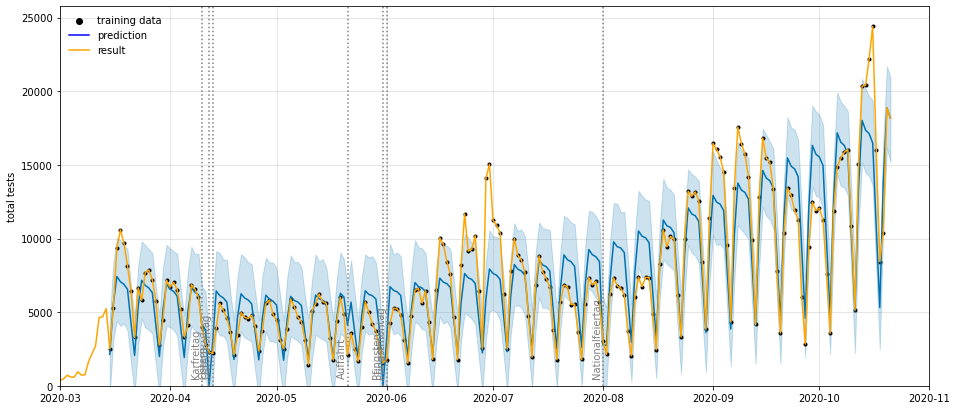

In [12]:
_, m, forecast, considered_holidays = forecasting_results[region]

axs = plotting.plot_testcount_forecast(
    df_processed.xs(region).predicted_new_tests,
    m, forecast, considered_holidays
)
pyplot.show()

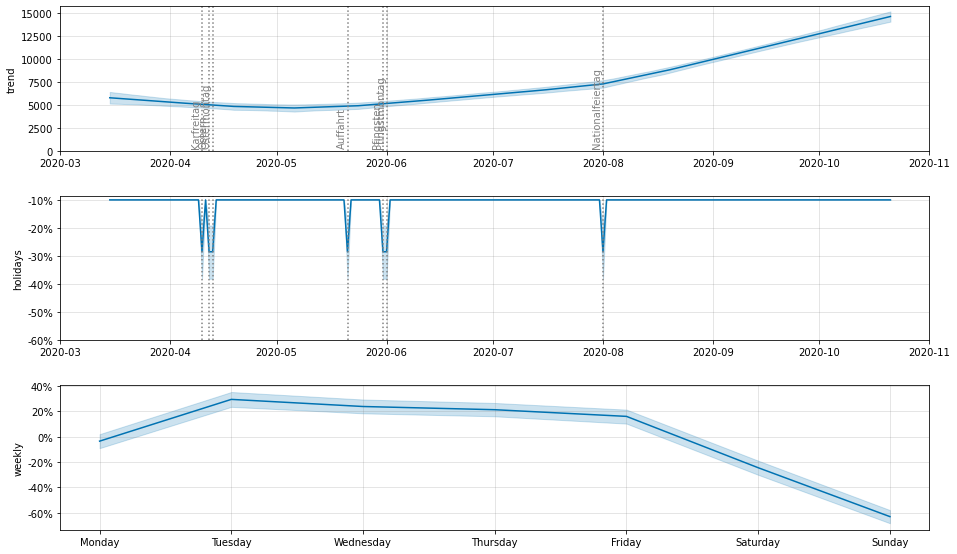

In [13]:
plotting.plot_testcount_components(m, forecast, considered_holidays);